# Detection Transformer

In [49]:
!nvidia-smi

Sun Feb  5 12:04:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 0. Chuẩn bị môi trường

In [52]:
%cd /content/drive/MyDrive/DETR
# !git clone https://github.com/facebookresearch/detr.git
%cd detr

/content/drive/MyDrive/DETR
/content/drive/MyDrive/DETR/detr


In [51]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Load và infer checkpoint

**Định nghĩa các hàm phụ trợ**

In [60]:
import math
import os

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [54]:
# Tên class trong COCO
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Màu sắc để visualize
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [55]:
# Transform tiêu chuẩn
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Chuyển (cx, cy, w, h) => (x1, y1, x2, y2)
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Chuyển tọa độ tương đối về kích thước thật
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [62]:
# Vẽ các bbox lên trên ảnh gốc
def plot_results(pil_img, prob, boxes, path):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

**Load pretrained model**

In [57]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Inference**

In [68]:
# Load ảnh
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [69]:
img_dir = '/content/drive/MyDrive/DETR/imgs'

In [70]:
# Infer với batch 1
img = transform(im).unsqueeze(0)

# Forward ảnh qua mô hình
outputs = model(img)

# Lọc những bbox có độ tự tin hơn 90%
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# Chuyển đổi tọa độ tương đối về tọa độ tuyệt đ
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

In [71]:
save_path = os.path.join(img_dir, url.split(os.path.sep)[-1])
plot_results(im, probas[keep], bboxes_scaled, save_path)

Output hidden; open in https://colab.research.google.com to view.

## 2. Visualize output từ Encoder và Decoder

Trích xuất weight của layer cuối cùng trong encoder và decoder. Thông qua việc visualize output này, ta có thể biết mô hình đang tập trung (attend) vào khu vực nào trên ảnh.

In [72]:
# Trích xuất weight của các layer sử dụng hooks
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# Forward ảnh qua mô hình
outputs = model(img)

for hook in hooks:
    hook.remove()

# Lấy ra weight của từng layer
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

print('Kích thước đặc trưng của Convolution: ', conv_features['0'].tensors[0].shape)
print('Kích thước attention của Encoder:     ', enc_attn_weights[0].shape)
print('Kích thước attention của Decoder:     ', dec_attn_weights[0].shape)

Kích thước đặc trưng của Convolution:  torch.Size([2048, 25, 34])
Kích thước attention của Encoder:      torch.Size([850, 850])
Kích thước attention của Decoder:      torch.Size([100, 850])


**Nhận xét:**
- Kích thước feature map của mạng Resnet50 là 34x25 = 850 pixel
- Kích thước weight của self-attention map trong decoder là (850, 850) hay là độ ảnh hưởng của 850 pixel lên chính nó
- Kích thước của attention map trong decoder là (100, 850) nghĩa là ảnh hưởng của 850 output bên encoder lên 100 output của decoder (100 là số vật thể tối đa)

**Visualize weight của decoder**

Đây là các attention output ứng với những vật thể có confidence cao nhất.

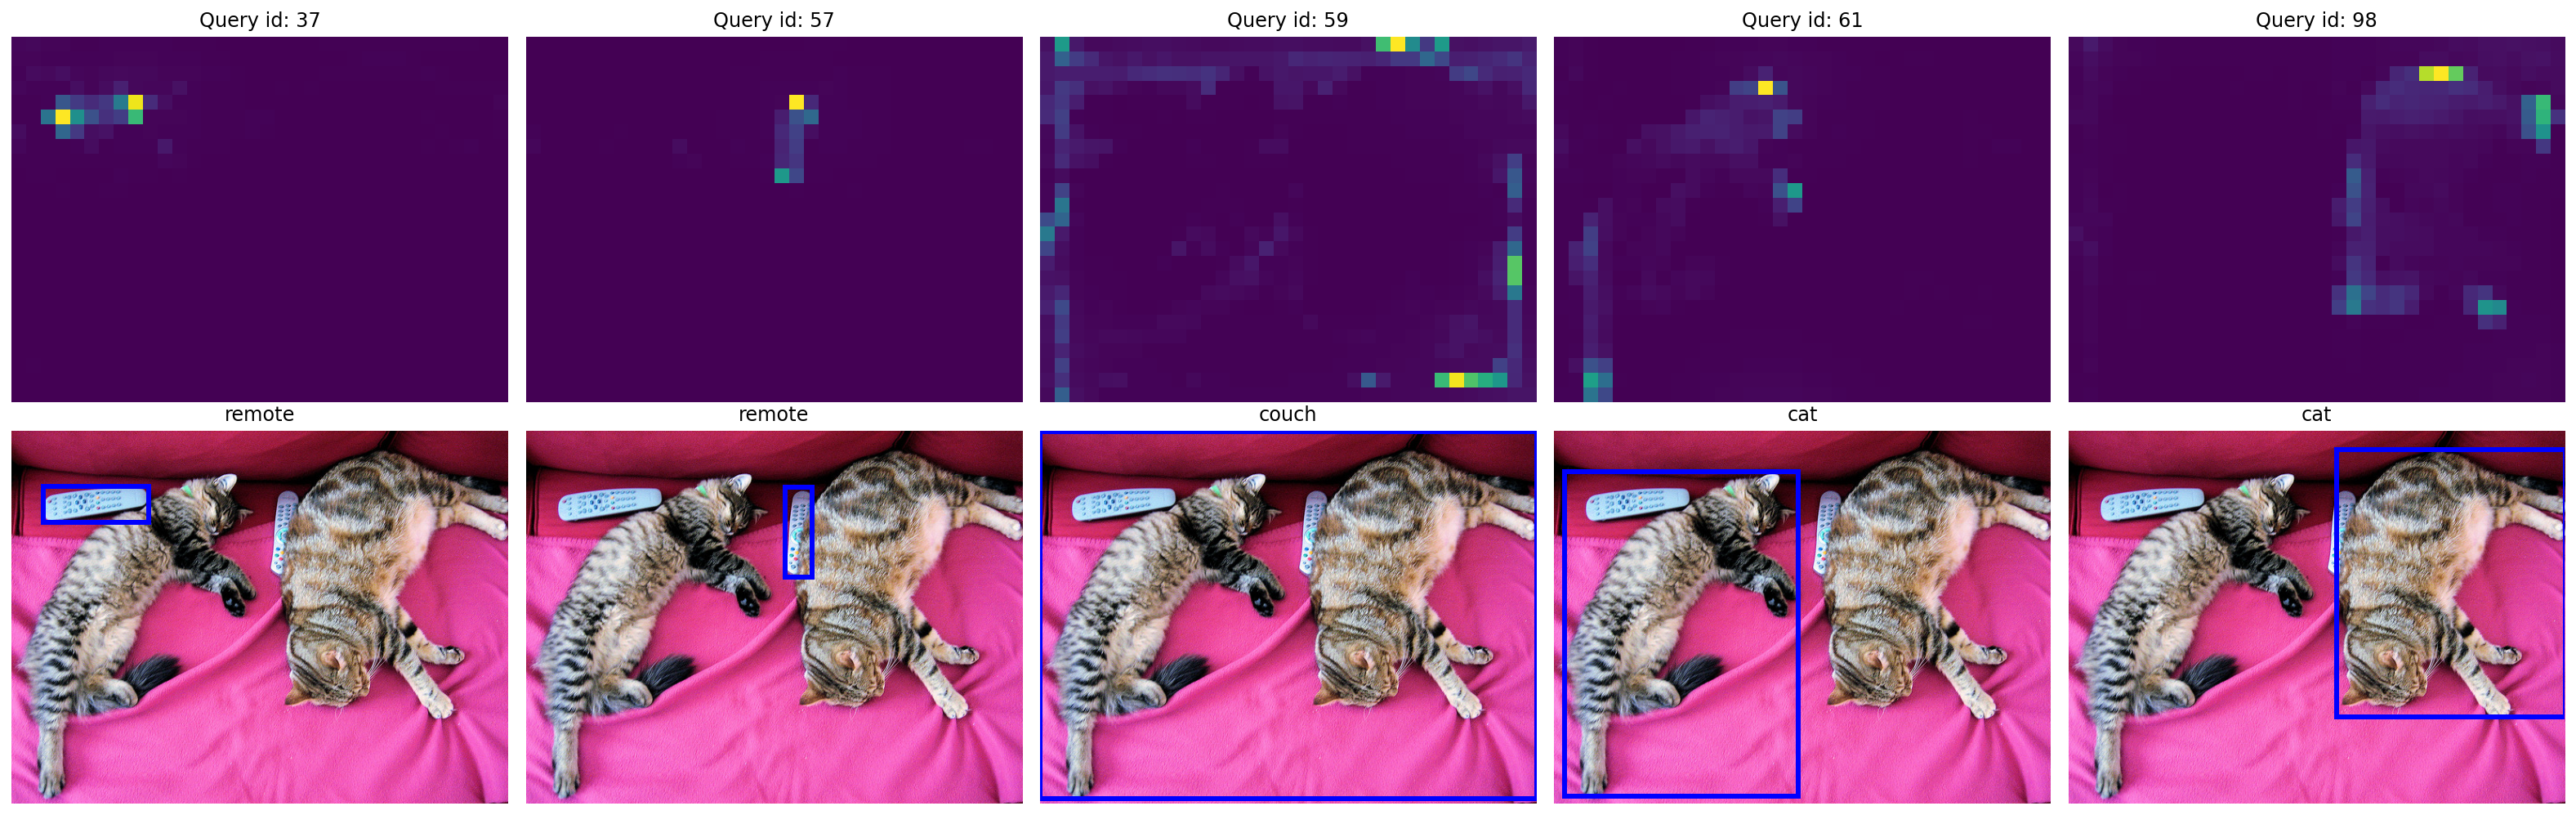

In [73]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'Query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()
plt.savefig(os.path.join(img_dir, 'decoder_attention.jpg'))

**Visualize weight của encoder**

In [74]:
# Output của mạng CNN
f_map = conv_features['0']
shape = f_map.tensors.shape[-2:]

# Reshape weight của attention về dạng (H, W, H, W)
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Shape mới của encoder:", sattn.shape)

Shape mới của encoder: torch.Size([25, 34, 25, 34])


In [78]:
# downsampling factor
fact = 32

# Chọn 4 điểm trên ảnh và quan sát attention của encoder tới điểm đó
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# Tạo canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# Plot self-attention cho từng điểm đó
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# Vẽ các điểm đang quan sát
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

fig.savefig(os.path.join(img_dir, 'encoder_attention.jpg'))

Output hidden; open in https://colab.research.google.com to view.

## 3. Đánh giá mô hình

Thông tin đánh giá
- Checkpoint: DETR Resnet50
- Dataset: COCO2017 (val) 5k ảnh

In [ ]:
# Đường dẫn tới checkpoint
url = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'

# Đường dẫn tới Dataset
data_path = '/content/drive/MyDrive/Datasets/coco'

In [ ]:
# Đánh giá mô hình
!python main.py --batch_size 2 --no_aux_loss --eval --resume {url} --coco_path {data_path}

Not using distributed mode
git:
  sha: 8a144f83a287f4d3fece4acdf073f387c5af387d, status: clean, branch: main

Namespace(aux_loss=False, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/drive/MyDrive/Datasets/coco', dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=True, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: User

**Nhận xét:**
- Mô hình đạt AP 0.42
- Mô hình đạt kết quả khá cao trên object lớn (0.611) do sử dụng transformer encoder để tạo ra global features cho ảnh
- Mô hình đạt kết quả thấp trên object nhỏ (0.205)

## 4. Phân tích lỗi

Thử nghiệm mô hình trên một số ảnh có nhiều vật thể nhỏ.

In [64]:
# Những ảnh có nhiều vật thể nhỏ trong COCO2017 valset
small_objs_images = [
    '000000000139',
    '000000000632',
    '000000018380',
    '000000031296',
    '000000127394',
    '000000150638',
    '000000303713',
    '000000304404',
    '000000379441'
]

In [66]:
for id in small_objs_images:
  print("Detect ảnh id {}".format(id))
  # Load ảnh
  url = 'http://images.cocodataset.org/val2017/{}.jpg'.format(id)
  im = Image.open(requests.get(url, stream=True).raw)

  # Infer với batch 1
  img = transform(im).unsqueeze(0)

  # Forward ảnh qua mô hình
  outputs = model(img)

  # Lọc những bbox có độ tự tin hơn 90%
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # Chuyển đổi tọa độ tương đối về tọa độ tuyệt đ
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  save_path = os.path.join(img_dir, url.split(os.path.sep)[-1])
  plot_results(im, probas[keep], bboxes_scaled, save_path)

Output hidden; open in https://colab.research.google.com to view.

**Nhận xét:** Nhiều object nhỏ bị miss trong quá trình detect